# DSCI 552 Project

#### Name: Boyu Shen
#### Github username: boyushen0701
#### USC ID: 3547352504

1.Transfer Learning for Image Classification

(a)
In this problem, we are trying to build a classifier that distinguishes images of 20
bird species. You are provided with text data in twenty folders.

(b)
Data Exploration and Pre-processing

i.Images in each class are given in separate folders. The file
Classes.xlsx
pro-
vides the classes assigned to the bird species images in each folder. Therefore,
you encode your classes using one-hot encoding and
Classes.xlsx

In [52]:
!pip install -U efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.7 MB/s 


In [53]:
from google.colab import drive
import pandas as pd
import numpy as np
import splitfolders
import keras
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
import efficientnet.keras as efn

In [3]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
#Retrieving data
drive.mount("/content/drive")

# read data from excel
data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/552 project/data/Classes.xlsx', sheet_name=0)

#Create an instance of One-hot-encoder
enc=OneHotEncoder()
  
#Passing encoded columns
enc_data=pd.DataFrame(enc.fit_transform(data[['Class']]).toarray())
  
#Merge with main
New_df=data.join(enc_data) 
print(New_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                     Folder Name   Class    0    1    2    3    4    5    6  \
0              005.Crested_Auklet      0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1                    013.Bobolink      1  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
2              015.Lazuli_Bunting      2  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
3            023.Brandt_Cormorant      3  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
4      040.Olive_sided_Flycatcher      4  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
5   041.Scissor_tailed_Flycatcher      5  0.0  0.0  0.0  0.0  0.0  1.0  0.0   
6            067.Anna_Hummingbird      6  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
7             072.Pomarine_Jaeger      7  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8             076.Dark_eyed_Junco      8  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9             081.Pied_Kingfisher      9  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10

ii. Randomly select [0.7ni] images from each folder as your training set, [0.15ni] as validation set, and the rest as your test set, where ni is the number of images in folder i and dxe is the ceiling of x.

In [10]:
inputfolder = '/content/drive/My Drive/Colab Notebooks/552 project/data/images'
splitfolders.ratio(inputfolder, output="/content/drive/My Drive/Colab Notebooks/552 project/data/output", seed=1, ratio=(.7, 0.15,0.15)) 

Copying files: 1176 files [11:32,  1.70 files/s]


iii. In order for all the images to have the same size, zero-pad or resize the images
in your dataset. This can be done using various tools, including OpenCV

In [58]:
img_width, img_height = 224, 224
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

(c) Transfer Learning

i. In this project, you will use pre-trained models EfficientNetB0 and VGG16. For both pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

In [59]:
#load the base model
vgg16_base = VGG16(input_shape = input_shape, # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')



base_model=vgg16_base
for layer in base_model.layers:
    layer.trainable = False


ii. To perform empirical regularization, crop, randomly zoo, rotate, flip, contrast,and translate images in your training set for image augmentation. You can
use various tools to do this, including OpenCV.

In [60]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/552 project/data/output/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/552 project/data/output/val'
batch_size = 5

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')



Found 820 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


iii. Use ReLU activation functions in the last layer and a softmax layer, along
with batch normalization 4 and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size,
but a batch size of 5 seems reasonable.

In [61]:
x = layers.Flatten()(base_model.output)

x = layers.BatchNormalization()(x)

# Add a fully connected layer with 20 hidden units and ReLU activation
x = layers.Activation(activations.relu)(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(20, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

#loss_fn = keras.losses.CategoricalCrossentropy()
op = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss ='categorical_crossentropy', optimizer = op, metrics = ['acc'])


iv. Train the networks (EfficientNetB0 and VGG16) for at least 50 epochs
(preferably 100 epochs) and perform early stopping using the validation set.
Keep the network parameters that have the lowest validation error. Plot the
training and validation errors vs. epochs.

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    min_delta=0.001, 
    mode='min'
)
hist1=model.fit(
    train_generator,
    steps_per_epoch=16,
    epochs=50,
    validation_data= validation_generator,
    validation_steps=3,
    callbacks=[early_stopping])

model.save_weights('/content/drive/My Drive/Colab Notebooks/552 project/data/weights1.h5')

Epoch 1/50
16/16 [==============================] - 3s 120ms/step - loss: 5.3131 - acc: 0.0500 - val_loss: 5.9922 - val_acc: 0.0667
Epoch 2/50
16/16 [==============================] - 2s 103ms/step - loss: 4.7691 - acc: 0.2500 - val_loss: 4.7185 - val_acc: 0.0667
Epoch 3/50
16/16 [==============================] - 2s 98ms/step - loss: 4.3385 - acc: 0.2875 - val_loss: 4.0115 - val_acc: 0.1333
Epoch 4/50
16/16 [==============================] - 2s 99ms/step - loss: 3.2303 - acc: 0.3500 - val_loss: 3.3757 - val_acc: 0.2667
Epoch 5/50
16/16 [==============================] - 2s 102ms/step - loss: 3.4474 - acc: 0.4125 - val_loss: 4.4189 - val_acc: 0.1333
Epoch 6/50
16/16 [==============================] - 2s 101ms/step - loss: 3.1501 - acc: 0.4250 - val_loss: 3.8554 - val_acc: 0.2000
Epoch 7/50
16/16 [==============================] - 2s 99ms/step - loss: 2.8851 - acc: 0.4625 - val_loss: 5.1245 - val_acc: 0.0667
Epoch 8/50
16/16 [==============================] - 2s 99ms/step - loss: 3.8047

In [64]:
# perform the same process on EfficientNetB0
base_model = efn.EfficientNetB0(input_shape = input_shape, include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)

x = layers.BatchNormalization()(x)

# Add a fully connected layer with 20 hidden units and ReLU activation
x = layers.Activation(activations.relu)(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(20, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

#loss_fn = keras.losses.CategoricalCrossentropy()
op = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss ='categorical_crossentropy', optimizer = op, metrics = ['acc'])

hist2=model.fit(
    train_generator,
    steps_per_epoch=16,
    epochs=50,
    validation_data= validation_generator,
    validation_steps=3,
    callbacks=[early_stopping])

model.save_weights('/content/drive/My Drive/Colab Notebooks/552 project/data/weights2.h5')

Epoch 1/50
16/16 [==============================] - 8s 181ms/step - loss: 21.8699 - acc: 0.1250 - val_loss: 10.6135 - val_acc: 0.0667
Epoch 2/50
16/16 [==============================] - 2s 97ms/step - loss: 16.1663 - acc: 0.1375 - val_loss: 8.0862 - val_acc: 0.3333
Epoch 3/50
16/16 [==============================] - 2s 103ms/step - loss: 12.7011 - acc: 0.2625 - val_loss: 16.0828 - val_acc: 0.0667
Epoch 4/50
16/16 [==============================] - 2s 97ms/step - loss: 9.9693 - acc: 0.3000 - val_loss: 4.2722 - val_acc: 0.4667
Epoch 5/50
16/16 [==============================] - 2s 97ms/step - loss: 12.0045 - acc: 0.3000 - val_loss: 7.4210 - val_acc: 0.4667
Epoch 6/50
16/16 [==============================] - 2s 95ms/step - loss: 8.4287 - acc: 0.4250 - val_loss: 8.9951 - val_acc: 0.3333
Epoch 7/50
16/16 [==============================] - 2s 99ms/step - loss: 8.1359 - acc: 0.4125 - val_loss: 6.9201 - val_acc: 0.3333
Epoch 8/50
16/16 [==============================] - 2s 97ms/step - loss: 9.

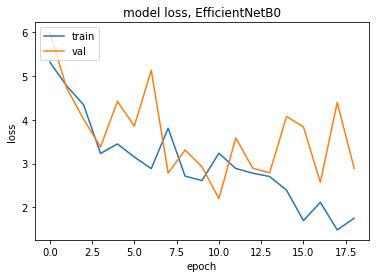

In [66]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model loss, VGG16')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

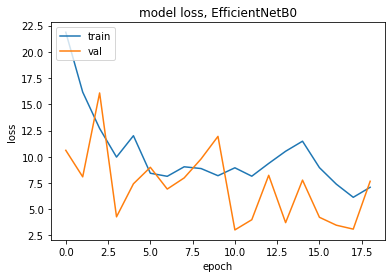

In [67]:
plt.figure()
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss, EfficientNetB0')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()